In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
from IPython.display import clear_output

In [4]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation

In [5]:
from utils.clustering import get_lda_clusters, get_vocab, word_topics_clustering, sort_meaningful, get_trf_clusters, topic_count

/home/cat/EPFL/Fall 2023/ADA/project_repo/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
characters =  pd.read_csv(
    'data/character_attributes.csv', 
    index_col=0,
    converters={
        "adj": lambda x: x.strip("[]").replace("'","").split(", "), # need this to read list columns from csv
        "active": lambda x: x.strip("[]").replace("'","").split(", "),
        "patient": lambda x: x.strip("[]").replace("'","").split(", ")
        }
    )
characters.head()

,wiki_id,character,adj,active,patient
0,31186339,Primrose Everdeen,[old],[choose],[]
1,31186339,Caesar Flickerman,[],[],[]
2,31186339,Peeta Mellark,[son],"[take, reveal, mean, form, present, beg, tell]",[force]
3,31186339,Cato,[],[kill],"[encounter, wound, shoot]"
4,31186339,Snow,[],"[summon, consider]",[]


In [7]:
characters = sort_meaningful(characters, 3)

In [8]:
len(characters)

74842

### Clusters from tv_tropes

In [9]:
import json

tropes_list=[]
with open('data/MovieSummaries/tvtropes.clusters.txt', 'r') as f:
    s = f.readline()
    while s:
        trope = s[:s.index('\t')]
        character = json.loads(s[s.index('\t'): ])
        character['trope'] = trope
        tropes_list.append(character)
        s = f.readline()
topres_df = pd.DataFrame(tropes_list)
topres_df.head()


movies = pd.read_csv(
    'data/MovieSummaries/movie.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'title', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres']
)
topres_df = topres_df.merge(movies, how='left', left_on='movie', right_on='title')[['char', 'movie', 'trope', 'wiki_id']]
topres_df

,char,movie,trope,wiki_id
0,Professor Philip Brainard,Flubber,absent_minded_professor,1344253
1,Professor Keenbean,Richie Rich,absent_minded_professor,1486573
2,Dr. Reinhardt Lane,The Shadow,absent_minded_professor,14143328
3,Dr. Reinhardt Lane,The Shadow,absent_minded_professor,29760749
4,Dr. Reinhardt Lane,The Shadow,absent_minded_professor,5991505
...,...,...,...,...
691,Morgan Earp,Tombstone,young_gun,525113
692,Colorado Ryan,Rio Bravo,young_gun,81100
693,Tom Sawyer,The League of Extraordinary Gentlemen,young_gun,4138142
694,William H. 'Billy the Kid' Bonney,Young Guns II,young_gun,675213


In [10]:
tropes_and_clusters = topres_df.merge(characters, how='left', left_on='wiki_id', right_on='wiki_id').dropna()
tropes_and_clusters

,char,movie,trope,wiki_id,character,adj,active,patient
0,Professor Philip Brainard,Flubber,absent_minded_professor,1344253,Philip Brainard,[professor],"[develop, approach, manage, discover, go, flun...","[lead, persuade]"
1,Professor Philip Brainard,Flubber,absent_minded_professor,1344253,Chester Hoenicker,[],"[send, discover]","[confront, defeat]"
2,Professor Philip Brainard,Flubber,absent_minded_professor,1344253,Sara Jean Reynolds,[],"[return, confront, defeat]","[steal, win]"
3,Professor Philip Brainard,Flubber,absent_minded_professor,1344253,Wilson Croft,[partner],[make],[defeat]
4,Professor Keenbean,Richie Rich,absent_minded_professor,1486573,Richard Rich,"[Sr, ., only]","[acquire, try, open, manage]",[shoot]
...,...,...,...,...,...,...,...,...
2875,Jake,Silverado,young_gun,2087781,Cobb,[sheriff],[],"[defy, kill]"
2876,Jake,Silverado,young_gun,2087781,Mal,[cowboy],"[find, reunite]",[]
2877,Jake,Silverado,young_gun,2087781,Emmett,[],"[ambush, find, ride, aid, learn, kill, leave]",[kill]
2878,Jake,Silverado,young_gun,2087781,Jake,[brother],"[learn, leave]",[aid]


In [11]:
def same_name(names1, names2):
    names1 = names1.values
    names2 = names2.values
    flag = []
    for i in range(len(names1)):
        flag.append(names2[i] in names1[i])
    return flag

tropes_and_clusters = tropes_and_clusters[same_name(tropes_and_clusters['char'], tropes_and_clusters['character'])]

In [12]:
characters_to_check = tropes_and_clusters[['character', 'adj', 'active', 'patient', 'trope', 'wiki_id', 'movie']].reset_index(drop=True)
characters_to_check

,character,adj,active,patient,trope,wiki_id,movie
0,Philip Brainard,[professor],"[develop, approach, manage, discover, go, flun...","[lead, persuade]",absent_minded_professor,1344253,Flubber
1,Keenbean,"[scientist, Smellmaster, RoboBee]","[listen, state]","[confront, rescue]",absent_minded_professor,1486573,Richie Rich
2,Reinhardt,"[father, scientist]",[disable],[rescue],absent_minded_professor,5991505,The Shadow
3,Daniel Jackson,"[professor, chance]","[accept, translate, deduce, reveal, go, realiz...","[offer, give, kill]",absent_minded_professor,28327,Stargate
4,Evelyn Carnahan,[sacrifice],"[present, visit, save, look, take, reveal, hyp...",[lead],adventurer_archaeologist,253828,The Mummy
...,...,...,...,...,...,...,...
412,Colorado Ryan,[gunslinger],"[decline, prove, offer, visit, step, throw, ag...",[],young_gun,81100,Rio Bravo
413,Tom Sawyer,[Quartermain],"[join, manage, go, take, manage]",[tell],young_gun,4138142,The League of Extraordinary Gentlemen
414,Billy,[],"[become, meet, find, pose, mention, come, refu...","[pardon, find]",young_gun,675213,Young Guns II
415,Kid,[],"[bring, remain, emerge]",[],young_gun,675213,Young Guns II


# Clustering evaluation

We want to see, how good our clustering algorithm performs compared to the original alorithm proposed in the paper [Learning Latent Personas of Film Characters](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf)

In [13]:
from math import log

def group_labels_by_clusters(clusters):
    _, clusters = np.unique(clusters, return_inverse=True)
    l = [[] for _ in range(np.max(clusters) + 1)]
    for i in range(len(clusters)):
        l[clusters[i]].append(i)
    return l

def variation_of_information(X, Y):
    n = float(sum([len(x) for x in X]))
    sigma = 0.0
    for x in X:
        p = len(x) / n
        for y in Y:
           q = len(y) / n
           r = len(set(x) & set(y)) / n
           if r > 0.0:
               sigma += r * (log(r / p, 2) + log(r / q, 2))
    return abs(sigma)

In [14]:
tv_tropes = group_labels_by_clusters(characters_to_check['trope'].values)

In [15]:
len(tv_tropes)

71

In [16]:
agglomerative_clusters_n = [25, 50, 100]
n_components = [25, 50, 100]

configs = {}
config_base = {'characters': characters_to_check, 'min_freq': 5, 'max_freq':0.9}

for alg_n in agglomerative_clusters_n:
    for n in n_components:
        config = config_base.copy()
        config['clustering_algo'] = AgglomerativeClustering(n_clusters=alg_n, metric='cosine', linkage='complete')
        config['n_components'] = n
        configs[f'{alg_n} topics, {n} archetypes'] = config

results_lda = {}
for k, config in configs.items():
    clusters = get_lda_clusters(**config)
    results_lda[k] = variation_of_information(group_labels_by_clusters(clusters), tv_tropes)
    print(k, f'VI = {results_lda[k]}')

clear_output(wait=True)
results_lda

{'25 topics, 25 archetypes': 6.2466797099799205,
 '25 topics, 50 archetypes': 5.721030072070011,
 '25 topics, 100 archetypes': 5.2078476164448135,
 '50 topics, 25 archetypes': 6.3319648575061835,
 '50 topics, 50 archetypes': 5.666473591455292,
 '50 topics, 100 archetypes': 4.976150571899939,
 '100 topics, 25 archetypes': 6.349160556531042,
 '100 topics, 50 archetypes': 5.607356379575675,
 '100 topics, 100 archetypes': 4.898739702618948}

Note, that the results are even better (K=100, P=100, 5.42 in the paper and 4.9 here) than the results from the [paper](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf). That could indicate that using word2vec embeddings and Agglomerative clustering of the words to topics might be better suited for dividing the words into topics for the purpose of personas extraction.

## BERT based clustering

In [17]:
characters_with_trf_emb =  pd.read_csv(
    'data/trf_embeddings_for_labeled_characters.csv', 
    index_col=0,
    converters={
        "emb": lambda x: [float(k) for k in x.strip("[]").replace("'","").split(", ")]
        }
    )
characters_with_trf_emb.head()

,wiki_id,character,emb
0,6002183,Horton,"[1.0488402843475342, 0.3811729848384857, 0.645..."
1,6002183,Ned McDodd,"[-0.5622232556343079, -0.2521360516548157, -0...."
2,6002183,JoJo,"[-0.7999439835548401, -0.4102073311805725, 0.6..."
3,6002183,Sally,"[0.7803803086280823, -0.7006192207336426, 0.32..."
4,6002183,LaRue,"[-0.038770418614149094, 0.219954714179039, -0...."


In [18]:
tropes_and_clusters = characters_to_check.merge(characters_with_trf_emb, how='left', left_on='wiki_id', right_on='wiki_id').dropna()
tropes_and_clusters = tropes_and_clusters[tropes_and_clusters['character_x'] == tropes_and_clusters['character_y']]
characters_to_check_trf = tropes_and_clusters[['character_y', 'emb', 'trope', 'wiki_id', 'movie']]

In [19]:
tv_tropes_trf = group_labels_by_clusters(characters_to_check_trf['trope'].values)

In [20]:
results_trf = {}
for n in n_components:
    k = f'{n} archetypes, agglomerative clustering'
    agglomerative = AgglomerativeClustering(n_clusters=n, metric='euclidean', linkage='complete')
    clusters = get_trf_clusters(characters_to_check_trf, agglomerative)
    results_trf[k] = variation_of_information(group_labels_by_clusters(clusters), tv_tropes_trf)
    print(k, f'VI = {results_trf[k]}')

    k = f'{n} archetypes, kmeans clustering'
    kmeans = KMeans(n_clusters=n)
    clusters = get_trf_clusters(characters_to_check_trf, kmeans)
    results_trf[k] = variation_of_information(group_labels_by_clusters(clusters), tv_tropes_trf)
    print(k, f'VI = {results_trf[k]}')

clear_output(wait=True)
results_trf

{'25 archetypes, agglomerative clustering': 6.120872572312354,
 '25 archetypes, kmeans clustering': 6.0820981557483265,
 '50 archetypes, agglomerative clustering': 5.554948748358468,
 '50 archetypes, kmeans clustering': 5.460425446028947,
 '100 archetypes, agglomerative clustering': 4.755176265593408,
 '100 archetypes, kmeans clustering': 4.588990915176862}

It's still better than the results from the paper, but extracting BERT embeddings is very slow, so we will stick to the previous method.

# Find optimal number of clusters

In [21]:
def medoid(vec):
    dist_matrix = np.zeros((len(vec), len(vec)))
    for i in range(len(vec)):
        for j in range(i + 1, len(vec)):
            dist_matrix[i][j] = np.sum(np.abs(vec[i] - vec[j]))
            dist_matrix[j][i] = dist_matrix[i][j]
    argmin = np.argmin(np.sum(dist_matrix, axis=0))
    return vec[argmin]

def unsupervised_evaluation(features, labels):
    unique_labels = np.unique(labels)
    # Calculate cluster medoid
    cluster_medoids = np.array([medoid(features[labels == label]) for label in unique_labels])

    # Calculate within-cluster sum of squares (WSS)
    wss = 0
    for num, label in enumerate(unique_labels):
        distance = np.sum((features[labels == label] - cluster_medoids[num]) ** 2)
        wss += distance

    sil_score = metrics.silhouette_score(features, labels)
    return wss, sil_score

In [22]:
characters_for_eval = characters.sample(1000).reset_index(drop=True)

In [23]:
clustering_algo = AgglomerativeClustering(n_clusters=200, metric='cosine', linkage='complete')

k_values = np.arange(10, 101, 5)
wsss = []
silhouettes = []
min_wss_idx = 0

for i in tqdm(range(len(k_values))):
    y, X = get_lda_clusters(characters_for_eval, 5, 0.9, clustering_algo, k_values[i], return_topic_counts=True)
    wss, silhouette = unsupervised_evaluation(X, y)
    wsss.append(wss)
    silhouettes.append(silhouette)
    clear_output(wait=True)

100%|██████████| 19/19 [01:31<00:00,  4.83s/it]


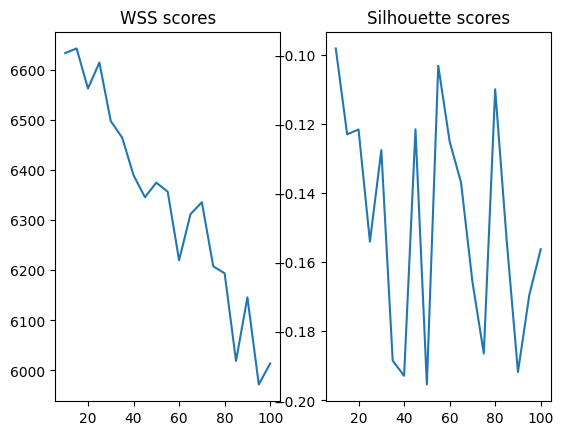

In [24]:
plt.subplot(1, 2, 1)
plt.plot(k_values, wsss)
plt.title("WSS scores")

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouettes)
plt.title("Silhouette scores")

plt.show()

We can see, that the 60 clusters provide relatively good combination of the silhouette and WSS scores and is still manageable to interpret.

In [25]:
optimal_k = 60

In [30]:
%%script false --no-raise-error
# We want to save components of lda and word clusters (topic_dict) as well as clustering

vocab, vocab_vectors = get_vocab(characters, 5, 0.9)
topic_dict = word_topics_clustering(vocab, vocab_vectors, clustering_algo)
counts = topic_count(characters, topic_dict)
lda = LatentDirichletAllocation(
        n_components=optimal_k, random_state=0
).fit(counts)

characters['cluster'] = lda.transform(counts).argmax(axis=1)

100%|██████████| 74842/74842 [00:07<00:00, 9682.37it/s] 


In [31]:
%%script false --no-raise-error

characters.to_csv('data/character_clusters.csv')

In [34]:
%%script false --no-raise-error
topic_to_words = {}

for k, v in topic_dict.items():
    v = str(v)
    if v in topic_to_words:
        topic_to_words[v].append(k)
    else:
        topic_to_words[v] = [k]
        
json.dump( topic_to_words, open( "data/words_by_topic.json", 'w' ) )

In [35]:
%%script false --no-raise-error

with open('data/lda_components.npy', 'wb') as f:
    np.save(f, lda.components_)